# Building a Machine Learning model of housing prices in a state using California Census data.

### Objective: To output a prediction of a district's median housing price. (District comprises 600-3000 people in the area)

Solution: A supervised learning task, a multiple univariate regression problem using batch learning process as data is old.

## Understanding Data

In [1]:
import os
import pandas as pd
import numpy as np

In [2]:
housing = pd.read_csv("datasets\housing\housing.csv")

In [3]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


After loading the data I will try to understand the insights from data.

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [5]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

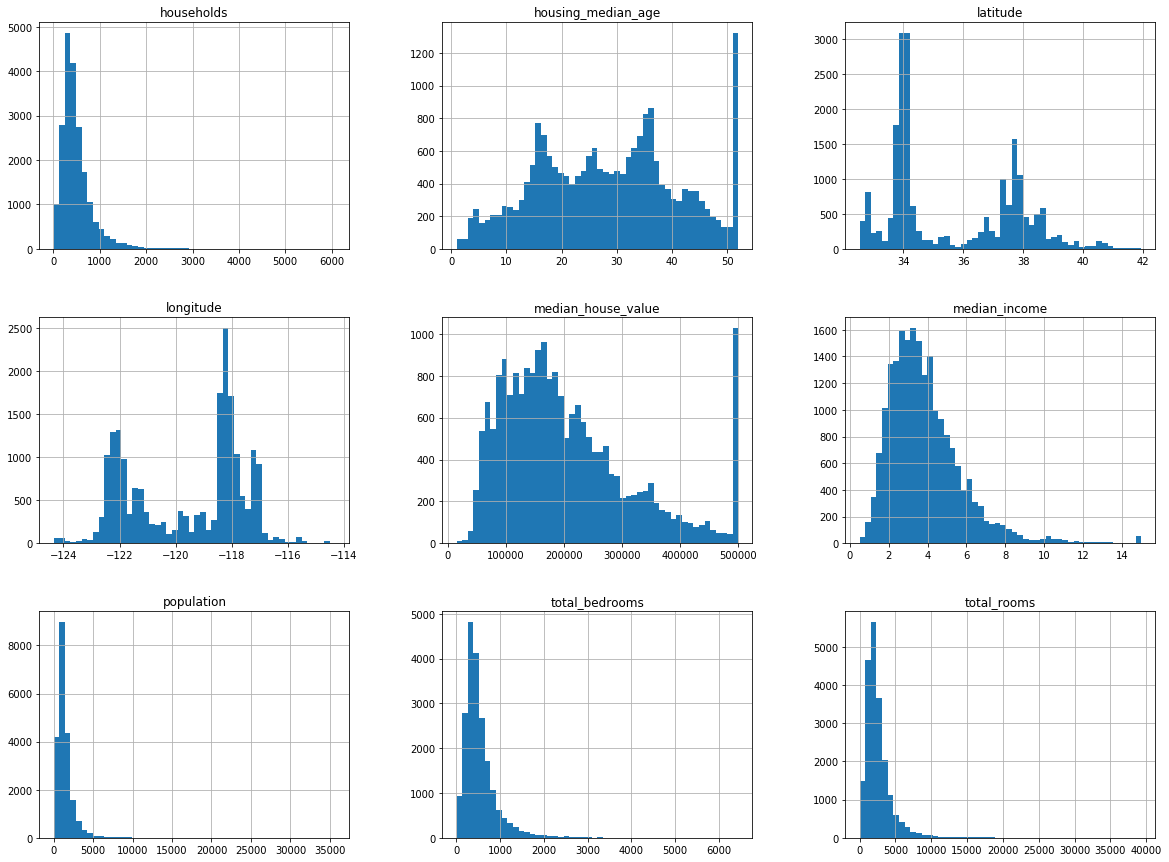

In [8]:
housing.hist(bins = 50, figsize = (20,15))
plt.show()

The histograms show that the median income attribute has been scaled and capped at 15ish for higher median incomes and 0.5ish for lower median incomes. Median age and median house value is also capped. We might have to perform feature scaling.

I could simply split data into 2 sets (say 20% of test set and 80% of training set). But that can introduce sampling bias. To prevent, I will create strata's based on median income as it is the most co-related attribute for median housing value. I will use stratified shuffle split function from sklearn

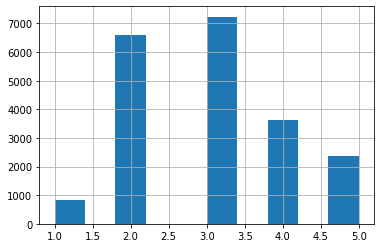

In [9]:
housing["income_cat"] = pd.cut(housing["median_income"], bins = [0., 1.5, 3.0, 4.5, 6., np.inf], labels = [1,2,3,4,5])
housing["income_cat"].hist()

I created an income category attribute with 5 categories with large enough strata's. If we never did that, we might get random data from the middle that would not generalize the new instances.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42) # 20% of data as test set with a random seed 42
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [11]:
len(strat_train_set)

16512

In [12]:
len(strat_test_set)

4128

Also, I will have same proportions data in both sets as I have in original, in random bias will be prevalent.

## Visualizing Data to gain insights

In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis = 1, inplace = True)

In [14]:
housing = strat_train_set.copy()

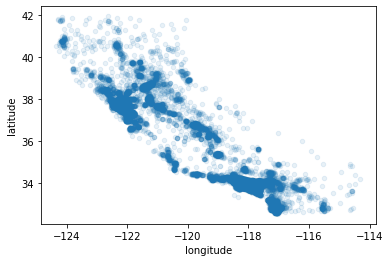

In [15]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.1) # great.. looks like california map.
# alpha reveals high density of data points

### Lets put data into more visually informative graph
#### Radius represents the price, blue represents less price and red represents high price.

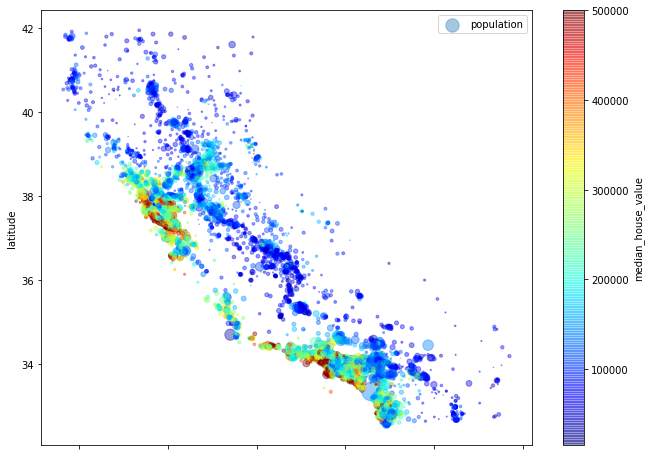

In [16]:
housing.plot(kind = "scatter", x = "longitude", y = "latitude", alpha = 0.4, s = housing["population"]/100, label = "population", figsize = (11,8), c = "median_house_value", cmap = plt.get_cmap("jet"), colorbar = True,)
plt.legend()

Most expensive properties are in areas with high population and proximity to bay area (Silicon Valley). A clustering algorithm can be used to detect main cluster and for adding new features that measure the proximity to the cluster centres.

In [17]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
# as total rooms, bedrooms tells nothing, average rooms bedroom will be more useful to find correlation

In [18]:
corr_matrix = housing.corr()

In [19]:
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value     1.000000
median_income          0.687160
rooms_per_household    0.146285
total_rooms            0.135097
housing_median_age     0.114110
households             0.064506
total_bedrooms         0.047689
population            -0.026920
longitude             -0.047432
latitude              -0.142724
bedrooms_per_room     -0.259984
Name: median_house_value, dtype: float64

I can see median income and newly created bedrooms_per_room has high correlation. Lets visualise correlation.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1A098A50>,
      dtype=object)

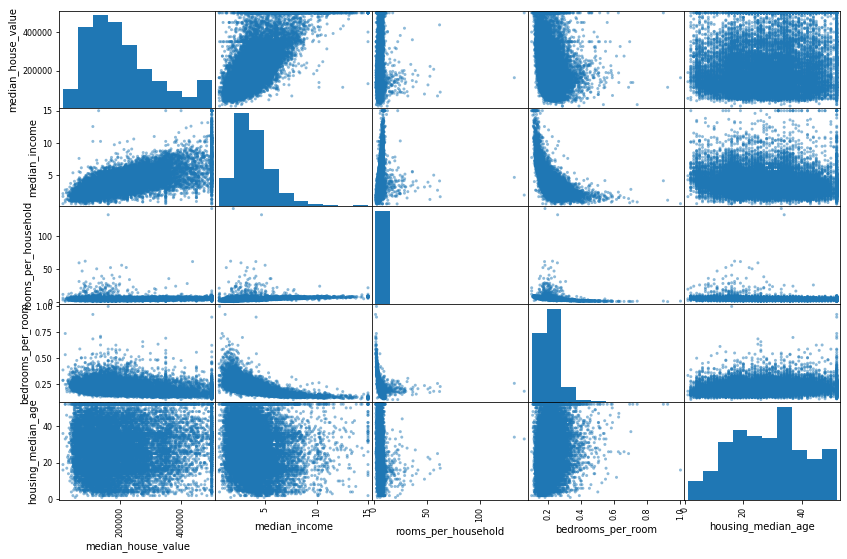

In [20]:
from pandas.plotting import scatter_matrix 
# latitude looks a good matric too
attributes = ["median_house_value", "median_income", "rooms_per_household", "bedrooms_per_room", "housing_median_age" ]
scatter_matrix(housing[attributes], figsize = (14,9))

These plots reveal a lot of insights and correlations. As well as few areas where we need to trim the data such as a unuseful straight line in median_house_value vs median_income aroung 500k and 450k.

# Data Cleaning 

In [21]:
strat_train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,286600.0,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,340600.0,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,196900.0,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,46300.0,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,254500.0,<1H OCEAN


In [22]:
housing = strat_train_set.drop("median_house_value", axis = 1)
housing_labels = strat_train_set["median_house_value"].copy()
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy = "median") # fill the missing values with the median values of the same
housing_num = housing.drop("ocean_proximity", axis = 1) # since median can be calculated on numerical value
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [23]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [24]:
X = imputer.transform(housing_num)  # this will remove the missing values with the learned medians.

In [25]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index = list(housing.index.values))

In [26]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [27]:
from sklearn.preprocessing import OrdinalEncoder
# I will process the categorical data as ML algorithms are better with number
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [28]:
# one hot encoder is better than ordinal encoder(found out later)
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot # returns a sparse array which is better in memory management

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

### I will create a custom transformer engine to process data

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [30]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"])
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


## Rather than doing separately for Categorical and Numerical data, I will create a pipeline to process all.

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([ # this pipeline is only for numerical data
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [32]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

# Training a model 
## The model I have tried is Decision Tree Regressor, Random Tree Regressor and Support Vector Regression (From SVM)
### I will try to find the best fit model

In [33]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [34]:
from sklearn.metrics import mean_squared_error

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

###  Further fine tuning the model. Also rmse 0 for the training set has to be rechecked

In [35]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


## Random Forest Regressor

In [36]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [37]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18603.515021376355

## Support Vector Regression from SVM

In [44]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(housing_prepared, housing_labels)
housing_predictions = svm_reg.predict(housing_prepared)
svm_mse = mean_squared_error(housing_labels, housing_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

111094.6308539982

### Lets find the best parameters and traing model Random Forest Reg

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)


In [46]:
rnd_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [47]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49150.657232934034 {'max_features': 7, 'n_estimators': 180}
51389.85295710133 {'max_features': 5, 'n_estimators': 15}
50796.12045980556 {'max_features': 3, 'n_estimators': 72}
50835.09932039744 {'max_features': 5, 'n_estimators': 21}
49280.90117886215 {'max_features': 7, 'n_estimators': 122}
50774.86679035961 {'max_features': 3, 'n_estimators': 75}
50682.75001237282 {'max_features': 3, 'n_estimators': 88}
49608.94061293652 {'max_features': 5, 'n_estimators': 100}
50473.57642831875 {'max_features': 3, 'n_estimators': 150}
64429.763804893395 {'max_features': 5, 'n_estimators': 2}


In [48]:
rnd_search.best_params_

{'max_features': 7, 'n_estimators': 180}

In [49]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([7.24699052e-02, 6.38080322e-02, 4.27504395e-02, 1.65343807e-02,
       1.56100762e-02, 1.60929106e-02, 1.52149598e-02, 3.45178404e-01,
       5.74445360e-02, 1.08468449e-01, 7.05907498e-02, 8.77441303e-03,
       1.60563229e-01, 6.10403994e-05, 3.08961266e-03, 3.34886200e-03])

In [50]:
final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)
print(final_predictions[:10]) # some predictions in dollar amount

[487513.58333333 273568.90555556 222643.34444444 213248.88888889
 138771.11111111 133311.11111111  63466.11111111 421617.93333333
 103867.22222222 105121.11111111]


In [51]:
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

46910.92117024934

# Above are predictions for test data(below) and with error rmse = 46910 which is good. 

## For example for the data group 
longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
5241     -118.39     34.12                29.0       6447.0          1012.0 

## Prediction of house price is $ 487513.58333333

In [52]:
print(X_test[:10])

       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
5241     -118.39     34.12                29.0       6447.0          1012.0   
10970    -117.86     33.77                39.0       4159.0           655.0   
20351    -119.05     34.21                27.0       4357.0           926.0   
6568     -118.15     34.20                52.0       1786.0           306.0   
13285    -117.68     34.07                32.0       1775.0           314.0   
20552    -121.80     38.68                11.0       3851.0           892.0   
19989    -119.32     36.19                11.0       1281.0           291.0   
17049    -122.26     37.46                26.0       5067.0           750.0   
13692    -117.24     34.13                26.0       3774.0           716.0   
13916    -116.15     34.14                18.0       3312.0           705.0   

       population  households  median_income ocean_proximity  
5241       2184.0       960.0         8.2816       <1H OCEAN  
1097